In [322]:

import glob
import os
import shutil
import cv2

import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from pipeline.python.utils import convert_range, label_figure, natural_keys


In [2]:
%matplotlib notebook

In [3]:
import matplotlib.ticker as ticker

def format_ticks(x):
    return '%.1f' % round(x, 2)

In [375]:
import math

def py_ang(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'    """
    cosang = np.dot(v1, v2)
    sinang = la.norm(np.cross(v1, v2))
    return np.arctan2(sinang, cosang)

def gradient_phase(f, *varargs, **kwargs):
    """
    Return the gradient of an N-dimensional array.
    The gradient is computed using second order accurate central differences
    in the interior and either first differences or second order accurate
    one-sides (forward or backwards) differences at the boundaries. The
    returned gradient hence has the same shape as the input array.
    Parameters
    ----------
    f : array_like
        An N-dimensional array containing samples of a scalar function.
    varargs : scalar or list of scalar, optional
        N scalars specifying the sample distances for each dimension,
        i.e. `dx`, `dy`, `dz`, ... Default distance: 1.
        single scalar specifies sample distance for all dimensions.
        if `axis` is given, the number of varargs must equal the number of axes.
    edge_order : {1, 2}, optional
        Gradient is calculated using N\ :sup:`th` order accurate differences
        at the boundaries. Default: 1.
        .. versionadded:: 1.9.1
    axis : None or int or tuple of ints, optional
        Gradient is calculated only along the given axis or axes
        The default (axis = None) is to calculate the gradient for all the axes of the input array.
        axis may be negative, in which case it counts from the last to the first axis.
        .. versionadded:: 1.11.0
    Returns
    -------
    gradient : list of ndarray
        Each element of `list` has the same shape as `f` giving the derivative
        of `f` with respect to each dimension.
    Examples
    --------
    >>> x = np.array([1, 2, 4, 7, 11, 16], dtype=np.float)
    >>> np.gradient(x)
    array([ 1. ,  1.5,  2.5,  3.5,  4.5,  5. ])
    >>> np.gradient(x, 2)
    array([ 0.5 ,  0.75,  1.25,  1.75,  2.25,  2.5 ])
    For two dimensional arrays, the return will be two arrays ordered by
    axis. In this example the first array stands for the gradient in
    rows and the second one in columns direction:
    >>> np.gradient(np.array([[1, 2, 6], [3, 4, 5]], dtype=np.float))
    [array([[ 2.,  2., -1.],
            [ 2.,  2., -1.]]), array([[ 1. ,  2.5,  4. ],
            [ 1. ,  1. ,  1. ]])]
    >>> x = np.array([0, 1, 2, 3, 4])
    >>> dx = np.gradient(x)
    >>> y = x**2
    >>> np.gradient(y, dx, edge_order=2)
    array([-0.,  2.,  4.,  6.,  8.])
    The axis keyword can be used to specify a subset of axes of which the gradient is calculated
    >>> np.gradient(np.array([[1, 2, 6], [3, 4, 5]], dtype=np.float), axis=0)
    array([[ 2.,  2., -1.],
           [ 2.,  2., -1.]])
    """
    f = np.asanyarray(f)
    N = len(f.shape)  # number of dimensions

    axes = kwargs.pop('axis', None)
    if axes is None:
        axes = tuple(range(N))
    # check axes to have correct type and no duplicate entries
    if isinstance(axes, int):
        axes = (axes,)
    if not isinstance(axes, tuple):
        raise TypeError("A tuple of integers or a single integer is required")

    # normalize axis values:
    axes = tuple(x + N if x < 0 else x for x in axes)
    if max(axes) >= N or min(axes) < 0:
        raise ValueError("'axis' entry is out of bounds")

    if len(set(axes)) != len(axes):
        raise ValueError("duplicate value in 'axis'")

    n = len(varargs)
    if n == 0:
        dx = [1.0]*N
    elif n == 1:
        dx = [varargs[0]]*N
    elif n == len(axes):
        dx = list(varargs)
    else:
        raise SyntaxError(
            "invalid number of arguments")

    edge_order = kwargs.pop('edge_order', 1)
    if kwargs:
        raise TypeError('"{}" are not valid keyword arguments.'.format(
                                                  '", "'.join(kwargs.keys())))
    if edge_order > 2:
        raise ValueError("'edge_order' greater than 2 not supported")

    # use central differences on interior and one-sided differences on the
    # endpoints. This preserves second order-accuracy over the full domain.

    outvals = []

    # create slice objects --- initially all are [:, :, ..., :]
    slice1 = [slice(None)]*N
    slice2 = [slice(None)]*N
    slice3 = [slice(None)]*N
    slice4 = [slice(None)]*N

    otype = f.dtype.char
    if otype not in ['f', 'd', 'F', 'D', 'm', 'M']:
        otype = 'd'

    # Difference of datetime64 elements results in timedelta64
    if otype == 'M':
        # Need to use the full dtype name because it contains unit information
        otype = f.dtype.name.replace('datetime', 'timedelta')
    elif otype == 'm':
        # Needs to keep the specific units, can't be a general unit
        otype = f.dtype

    # Convert datetime64 data into ints. Make dummy variable `y`
    # that is a view of ints if the data is datetime64, otherwise
    # just set y equal to the array `f`.
    if f.dtype.char in ["M", "m"]:
        y = f.view('int64')
    else:
        y = f

    for i, axis in enumerate(axes):

        if y.shape[axis] < 2:
            raise ValueError(
                "Shape of array too small to calculate a numerical gradient, "
                "at least two elements are required.")
        
        # Numerical differentiation: 1st order edges, 2nd order interior
        if y.shape[axis] == 2 or edge_order == 1:
            
            # Use first order differences for time data
            out = np.empty_like(y, dtype=otype)

            slice1[axis] = slice(1, -1)
            slice2[axis] = slice(2, None)
            slice3[axis] = slice(None, -2)
            # 1D equivalent -- out[1:-1] = (y[2:] - y[:-2])/2.0
            out[slice1] = (y[slice2] - y[slice3])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi
            out[slice1]=out[slice1]/2.0

            slice1[axis] = 0
            slice2[axis] = 1
            slice3[axis] = 0
            # 1D equivalent -- out[0] = (y[1] - y[0])
            out[slice1] = (y[slice2] - y[slice3])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi

            slice1[axis] = -1
            slice2[axis] = -1
            slice3[axis] = -2
            # 1D equivalent -- out[-1] = (y[-1] - y[-2])
            out[slice1] = (y[slice2] - y[slice3])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi

        # Numerical differentiation: 2st order edges, 2nd order interior
        else:
            # Use second order differences where possible
            out = np.empty_like(y, dtype=otype)

            slice1[axis] = slice(1, -1)
            slice2[axis] = slice(2, None)
            slice3[axis] = slice(None, -2)
            # 1D equivalent -- out[1:-1] = (y[2:] - y[:-2])/2.0
            out[slice1] = (y[slice2] - y[slice3])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi
            out[slice1] = out[slice1]/2

            slice1[axis] = 0
            slice2[axis] = 0
            slice3[axis] = 1
            slice4[axis] = 2
            # 1D equivalent -- out[0] = -(3*y[0] - 4*y[1] + y[2]) / 2.0
            out[slice1] = -(3.0*y[slice2] - 4.0*y[slice3] + y[slice4])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi
            out[slice1]=out[slice1]/2.0

            slice1[axis] = -1
            slice2[axis] = -1
            slice3[axis] = -2
            slice4[axis] = -3
            # 1D equivalent -- out[-1] = (3*y[-1] - 4*y[-2] + y[-3])
            out[slice1] = (3.0*y[slice2] - 4.0*y[slice3] + y[slice4])
            out[slice1] = (out[slice1] + math.pi) % (2*math.pi) - math.pi
            out[slice1]=out[slice1]/2.0

        # divide by step size
        out /= dx[i]
        outvals.append(out)

        # reset the slice object in this dimension to ":"
        slice1[axis] = slice(None)
        slice2[axis] = slice(None)
        slice3[axis] = slice(None)
        slice4[axis] = slice(None)

    if len(axes) == 1:
        return outvals[0]
    else:
        return outvals


# set output dir

In [31]:
outdir = os.path.join('/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps', 'signmaps') # 'figures')
if not os.path.exists(outdir):
    os.makedirs(outdir)


# Select dataset

In [323]:
# animalid = 'JC084'
# session = '20190517'

animalid = 'JC085'
session = '20190620'

#session = '20190522'
#fov = 'FOV1_zoom2p0x'
#retinorun = 'retino_run2'


fig_id = '%s_%s' % (animalid, session)

# Widefield

In [10]:
59.7782*2.
33.6615*2


67.323

In [6]:
screen_x = 119.5564
screen_y = 67.323
resolution = [1920, 1080] #[1024, 768]


In [7]:
surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'

analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


In [8]:
glob.glob(os.path.join(surface_basedir, animalid, session))

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620']

In [62]:
surface_path = glob.glob(os.path.join(surface_basedir, animalid, session, 'Surface', '*.png'))[0]
surface = cv2.imread(surface_path, -1)
surface.shape

(164, 218)

In [63]:
from matplotlib.colors import LinearSegmentedColormap


In [64]:
colors = [(0, 0, 0), (0, 1, 0), (0, 0, 0)]
LUT = LinearSegmentedColormap.from_list('gcamp', colors)
    

<IPython.core.display.Javascript object>


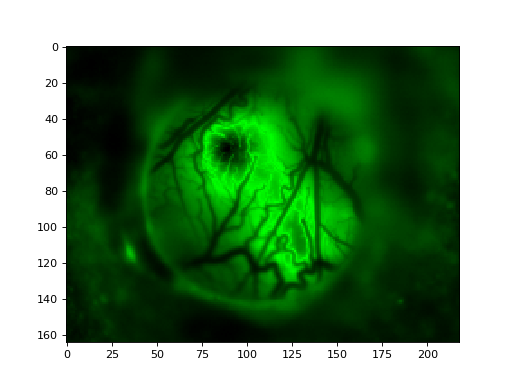

In [65]:
pl.figure()
pl.imshow(surface, cmap=LUT)

In [15]:

#animalid = 'JC085'
#session = '20190620'

datapaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'Files', '*.npz'))
datapaths

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/Files/cond2.0_averageTimeCourse.npz',
 '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/Files/cond3.0_averageTimeCourse.npz']

In [16]:
mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
print mappaths

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190620_cond2_maps.npz', '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190620_cond3_maps.npz']


In [17]:
datapaths

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/Files/cond2.0_averageTimeCourse.npz',
 '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/Files/cond3.0_averageTimeCourse.npz']

In [500]:
data_id = '-'.join([animalid, session])


# Load data

In [607]:

data = np.load(datapaths[0])
data.keys()

['groupPeriods',
 'meanPixelValue',
 'frameArrayAvg',
 'szX',
 'szY',
 'frameArrayGroupedAvg',
 'frameTimes',
 'frameCount']

In [608]:

d1, d2 = data['szX'], data['szY']


In [609]:
_, nframes = data['frameArrayAvg'].shape
farray = data['frameArrayAvg'] #np.reshape(data['frameArrayAvg'],  (d2, d1, nframes))
print(farray.shape)

(35752, 1922)


In [613]:
mov = np.reshape(farray, (d2, d1, nframes))
print(mov.shape)

(164, 218, 1922)


(1922, 164, 218)


<IPython.core.display.Javascript object>


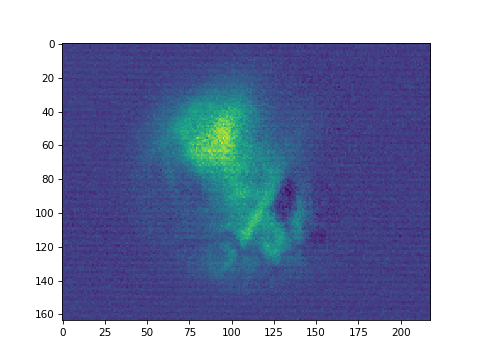

In [618]:
mov_ = np.swapaxes(mov.T, 1, 2)

print(mov_T.shape)
pl.figure()
pl.imshow(np.mean(mov_T, axis=0))

In [630]:
nframes

1922

In [629]:
fr = 1./np.diff(data['frameTimes']).mean()


In [637]:
freqs = np.fft.fftfreq(nframes, float(1/fr))
idx = np.argsort(freqs) 
freqs = freqs[idx]

freqs=freqs[np.round(nframes/2)+1:]
s_ix = np.round(nframes/2)+1

stim_freq = 0.13
freqIdx=np.where(freqs>stim_freq)[0][0]


In [619]:
power_mov = (np.abs(mov_T)*2.) / np.size(mov_T, 0)
print(power_mov.shape)


(1922, 164, 218)


In [638]:
power_map = np.abs(power_mov[freqIdx,:,:]) #np.abs(power_mov[1,:,:])

power_map.shape

(164, 218)

<IPython.core.display.Javascript object>


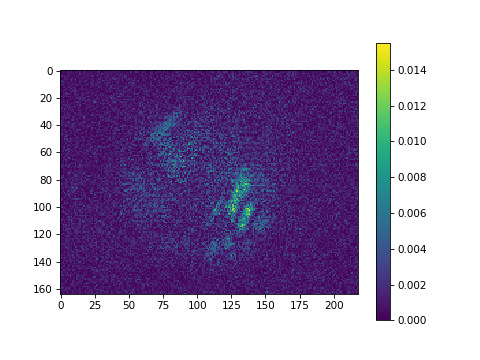

In [639]:
pl.figure()
pl.imshow(power_map)
pl.colorbar()

In [640]:
#generate phase movie
phase_mov = np.angle(mov_T)
p_map = -1 * phase_mov[freqIdx,:,:]
p_map = p_map % (2 * np.pi)

<IPython.core.display.Javascript object>


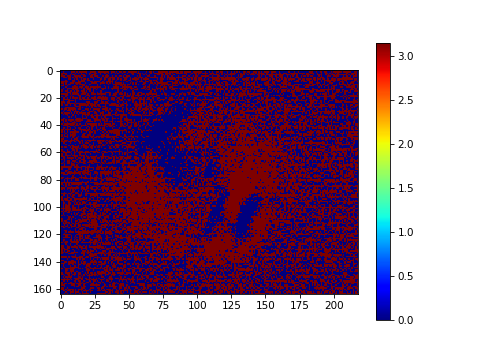

In [641]:
pl.figure()
pl.imshow(p_map, cmap='jet')
pl.colorbar()

In [ ]:
meanpix = data['meanPixelValue']
meanpix.shape

In [ ]:
np.expand_dims(meanpix,1).shape

In [ ]:
meanpix = np.expand_dims(meanpix,1)
meanpix_array = np.tile(meanpix, (1, farray.shape[1]))


In [ ]:
dff_array = np.true_divide(farray, meanpix_array)
dff_array.shape

In [ ]:
dff_img = np.reshape(dff_array, (d2, d1, nframes)).max(axis=-1)
dff_img.shape

In [ ]:

fig, ax = pl.subplots()
im = ax.imshow(dff_img, cmap='gray')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size='2%', pad=0.1, shrink=.5)
fig.colorbar(im, label='dF/F', shrink=0.5, pad=0.05)
ax.axis('off')

In [35]:

_, nframes_grouped = data['frameArrayGroupedAvg'].shape

farray_grouped = data['frameArrayGroupedAvg']#  np.reshape(data['frameArrayGroupedAvg'], (d2, d1, nframes))


In [36]:
meanpix.shape

(35752, 1)

In [37]:
nperiods_group = data['groupPeriods']
meanpix_grouped = np.tile(meanpix, (1, farray_grouped.shape[1]))
meanpix_grouped.shape


(35752, 383)

In [38]:
dff_array_grouped = np.true_divide(farray_grouped, meanpix_grouped)
dff_array_grouped.shape



(35752, 383)

In [39]:
dff_img_grouped = np.reshape(dff_array_grouped, (d2, d1, nframes_grouped)).max(axis=-1)
dff_img_grouped.shape

(164, 218)

In [40]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/figures'

<IPython.core.display.Javascript object>


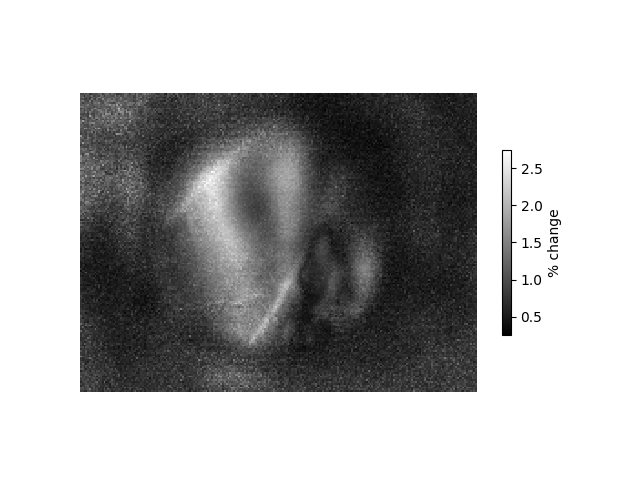

cond2-grouped-dff-image_JC085-20190620


In [41]:

fig, ax = pl.subplots()
im = ax.imshow(dff_img_grouped*100, cmap='gray')
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size='2%', pad=0.1, shrink=.5)
fig.colorbar(im, label='% change', shrink=0.5, pad=0.05, format='%.1f')
ax.axis('off')
figname = 'cond2-grouped-dff-image_%s' % data_id
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

In [42]:
dff = np.reshape(dff_array_grouped, (d2, d1, nframes_grouped))
print dff.shape

(164, 218, 383)


In [43]:
vmin, vmax = dff.min(), dff.max()
print vmin, vmax

-0.0214794324116 0.0274700482577


In [44]:
pos_x = convert_range(pmin, newmin=0, newmax=screen_x, oldmin=0, oldmax=pmax)


NameError: name 'pmin' is not defined

In [338]:
screen_x

119.5564

<IPython.core.display.Javascript object>


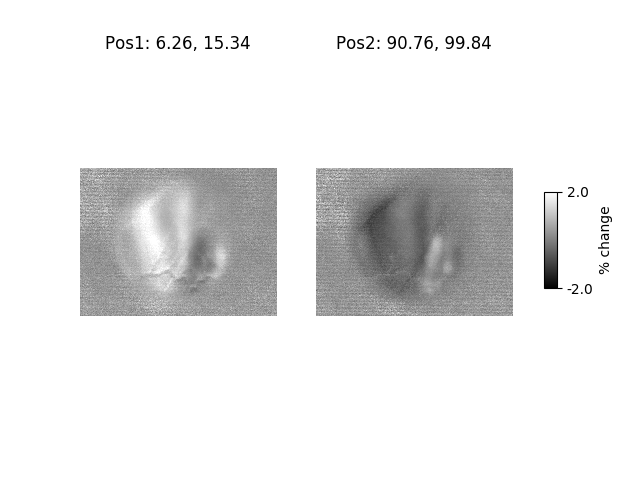

cond2-grouped-dff-binned-pos_gray_JC085-20190620


In [45]:
binsize=30
cmap = 'gray' #'PRGn'
vmax = 0.02 * 100
vmin = -0.02 * 100

s_ix1 = 20
s_ix2 = 290
s_ix3 = 280

degpos = np.linspace(0, screen_x, dff.shape[-1])
pos1_deg = degpos[s_ix1:s_ix1+binsize]
pos2_deg = degpos[s_ix2:s_ix2+binsize]
pos3_deg = degpos[s_ix3:s_ix3+binsize]

ixs1 = np.arange(s_ix1, s_ix1+binsize)
ixs2 = np.arange(s_ix2, s_ix2+binsize)
ixs3 = np.arange(s_ix3, s_ix3+binsize)

fig, axes = pl.subplots(1,2, sharex=True, sharey=True)
im= axes[0].imshow(dff[:, :, ixs1].max(axis=-1) * 100 , cmap=cmap, vmin=vmin, vmax=vmax)
im = axes[1].imshow(dff[:, :, ixs2].max(axis=-1) * 100, cmap=cmap, vmin=vmin, vmax=vmax)

for ax in axes:
    ax.axis('off')
    

axes[0].set_title("Pos1: %.2f, %.2f" % (pos1_deg[0], pos1_deg[-1]))
axes[1].set_title("Pos2: %.2f, %.2f" % (pos2_deg[0], pos2_deg[-1]))


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))


fig.colorbar(im, cax=cbar_ax, ticks=[vmin, vmax], label='% change')
cbar_ax.set_yticklabels([vmin, vmax])

#cbar_ax.set_yticks([cbar_ax.get_ylim()[0], cbar_ax.get_ylim()[-1]])
#cbar_ax.set_yticks([cbar_ax.get_ylim()[0], cbar_ax.get_ylim()[-1]])
figname = 'cond2-grouped-dff-binned-pos_%s_%s' % (cmap, data_id)

pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

# Select colormap

In [22]:
# Load colormap
# colormap = 'colorwheel'
# cmapdir = '/n/coxfs01/julianarhee/aggregate-visual-areas/colormaps'
# cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
# cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])

colormap ='Spectral_r'
cmap_phase = 'Spectral_r'
    

# Legends

In [23]:
deg_per_pixel = screen_x / float(resolution[0])


In [24]:
x = np.linspace(0, 2*np.pi, int(round(screen_x)))
y = np.linspace(0, 2*np.pi, int(round(screen_y)) )

xv, yv = np.meshgrid(x, y)


az_legend = (2*np.pi) - xv
el_legend = yv


In [25]:
# def convert_boundary(boundary_pix, center_deg ,deg_per_pixel):

#     boundary_deg = boundary_pix * deg_per_pixel
#     boundary_relative_deg = boundary_deg - center_deg
    
#     return boundary_relative_deg

In [26]:
az_screen = convert_range(az_legend, newmin=0, newmax=screen_x, oldmin=0, oldmax=2*np.pi)
el_screen = convert_range(el_legend, newmin=0, newmax=screen_x, oldmin=0, oldmax=2*np.pi)


In [27]:
az_screen.shape

(67, 120)

<IPython.core.display.Javascript object>


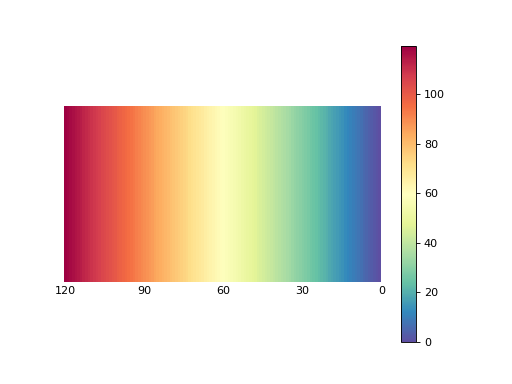

cond2-grouped-dff-binned-pos_Spectral_r_JC085-20190620_LEGEND_to2p


In [33]:
fig, ax = pl.subplots()
im = ax.imshow(az_screen, cmap=cmap_phase)
#ax.invert_xaxis()
pl.colorbar(im)
ax.set_xticks(np.linspace(0, int(round(screen_x)), 5))
ax.set_xticklabels([int(round(i)) for i in np.linspace(0, int(round(screen_x)), 5)][::-1])

#spos1, epos1 = pos1_deg[0], pos1_deg[-1]
#spos2, epos2 = pos2_deg[0], pos2_deg[-1]

#ax.axvline(x=screen_x-spos1, c='w')
#ax.axvline(x=screen_x-epos1, c='w')

#ax.axvline(x=screen_x-spos2, c='w')
#ax.axvline(x=screen_x-epos2, c='w')

ax.set_yticks([])
ax.set_yticklabels([])
ax.tick_params(axis='x', length=0)
ax.set_frame_on(False)
#ax.set_xlim(ax.get_xlim()[::-1])


figname = 'cond2-grouped-dff-binned-pos_%s_%s_LEGEND_to2p' % (colormap, data_id)

pl.savefig(os.path.join(outdir, '%s.png' % figname))
print figname

In [32]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps'

# Recolor maps

In [34]:
import cv2
from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


In [566]:


def process_maps(mapdata, smooth_fwhm=None, mag_thr=None, recenter=True):
    phase_az = mapdata['phaseMap'].copy()
    mag_az = mapdata['magRatioMap'].copy()
    
    # phase_az[mag_az<mag_thr]=np.nan

    if smooth_fwhm is not None:
        phase_az =smooth_array(phase_az, smooth_fwhm, phaseArray=True)
        mag_az = smooth_array(mag_az, smooth_fwhm)

    if recenter:
#         phaseC_az=np.copy(phase_az)
#         phaseC_az[phase_az<0]=-phase_az[phase_az<0]
#         phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
        phaseC_az = shift_map(phase_az)
        phasemin = 0
        phasemax = 2*np.pi
    else:
        phaseC_az = np.copy(phase_az)
        phasemin = -np.pi
        phasemax = np.pi


    phaseC_az[mag_az<mag_thr]=np.nan
    
    return phaseC_az, mag_az, phasemin, phasemax

def shift_map(phase_az):
    phaseC_az=np.copy(phase_az)
    if phase_az[~np.isnan(phase_az)].min() < 0 and phase_az[~np.isnan(phase_az)].max() > 0:
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
    else:
        print("Already non-negative (min/max: %.2f, %.2f)" % (phase_az.min(), phase_az.max()))
    return phaseC_az


# Load maps

In [37]:
mappaths

['/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190620_cond2_maps.npz',
 '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC085/20190620/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190620_cond3_maps.npz']

In [476]:
print os.path.split(mappaths[0])[-1]
mapdata_az = np.load(mappaths[0])
print(mapdata_az.keys())
mapdata_el = np.load(mappaths[1])

20190620_cond2_maps.npz
['nonTargetMagMap', 'varExpMap', 'magMap', 'betaMap', 'phaseMap', 'magRatioMap']


In [499]:
data_id

NameError: name 'data_id' is not defined

In [370]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps'

# Visualize retinotopic maps (average across reps)

<IPython.core.display.Javascript object>


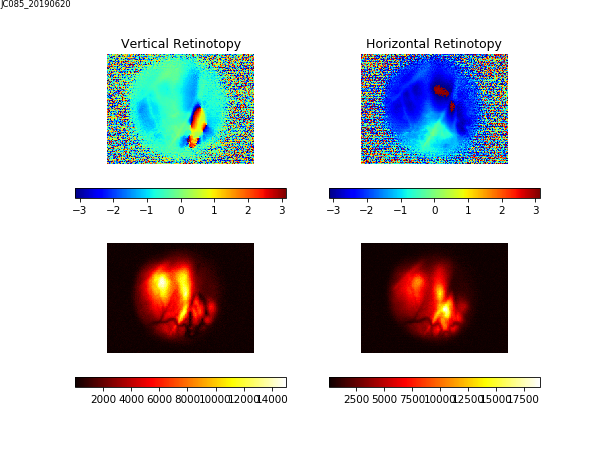

In [605]:
cmap = 'jet'
fig, axn = pl.subplots(2,2,figsize=(8,6))
for ai, cond_data in enumerate([mapdata_az, mapdata_el]):
    ax = axn[0, ai]
    im = ax.imshow(cond_data['phaseMap'], cmap=cmap)
    ax.axis('off')
    #cax = fig.add_axes([0.1+(ai*.4), 0.2, 0.3, 0.05])
    pl.colorbar(im, ax=ax, orientation='horizontal')
    title = 'Horizontal Retinotopy' if ai==1 else 'Vertical Retinotopy'
    ax.set_title(title)
    
    ax = axn[1, ai]
    im = ax.imshow(cond_data['magMap'], cmap='hot')
    ax.axis('off')
    #cax = fig.add_axes([0.1+(ai*.4), 0.2, 0.3, 0.05])
    pl.colorbar(im, ax=ax, orientation='horizontal')
    
label_figure(fig, fig_id)

pl.savefig(os.path.join(outdir, 'avg_retino_maps_%s_%s.png' % (cmap, data_id)))

In [603]:
(cond_data['magMap']**2).max()

360005517.20595902

## Smooth retino maps

In [569]:
smooth_fwhm = 7
recenter = True
mag_thr = 0.035

phase_az, mag_az, pmin, pmax = process_maps(mapdata_az, smooth_fwhm=smooth_fwhm, mag_thr=mag_thr, recenter=recenter)
phase_el, mag_el, pmin, pmax = process_maps(mapdata_el, smooth_fwhm=smooth_fwhm, mag_thr=mag_thr, recenter=recenter)

        

<IPython.core.display.Javascript object>


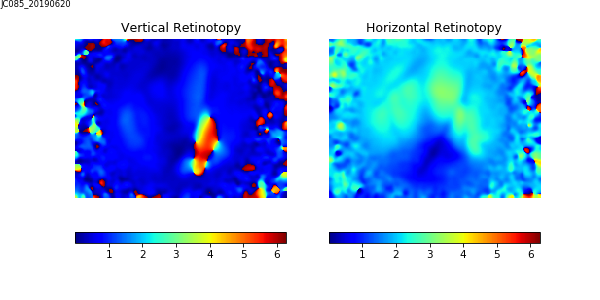

In [529]:
# smooth_fwhm = 7

phase_az_raw = mapdata_az['phaseMap'].copy()
phase_el_raw = mapdata_el['phaseMap'].copy()
phase_az_smooth = shift_map(smooth_array(phase_az_raw, smooth_fwhm, phaseArray=True))
phase_el_smooth = shift_map(smooth_array(phase_el_raw, smooth_fwhm, phaseArray=True))

cmap = 'jet'
fig, axn = pl.subplots(1,2,figsize=(8,4))
for ai, (ax, cond_map) in enumerate(zip(axn.flat, [phase_az_smooth, phase_el_smooth])):
    im = ax.imshow(cond_map, cmap=cmap)
    ax.axis('off')
    #cax = fig.add_axes([0.1+(ai*.4), 0.2, 0.3, 0.05])
    pl.colorbar(im, ax=ax, orientation='horizontal')
    title = 'Horizontal Retinotopy' if ai==1 else 'Vertical Retinotopy'
    ax.set_title(title)
    
label_figure(fig, fig_id)

#pl.savefig(os.path.join(outdir, 'avg_retino_maps_%s_%s.png' % (cmap, data_id)))

In [570]:


# fig, ax = pl.subplots()
# ax.imshow(surf, cmap='gray')
# im = ax.imshow(phase_az, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.8)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
# cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
# fig.colorbar(im, cax=cbar_ax, ticks=[pmin, pmax], label='phase')
# cbar_ax.set_yticklabels([round(pmin, 2), round(pmax,2)])

# figname = 'azimuth-phasemap_%s_%s' % (colormap, data_id)

# pl.savefig(os.path.join(outdir, '%s.png' % figname))
# print figname

In [530]:
# fig, ax = pl.subplots()
# ax.imshow(surf, cmap='gray')
# im = ax.imshow(phase_el, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
# cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
# fig.colorbar(im, cax=cbar_ax, ticks=[pmin, pmax], label='phase')
# #cbar_ax.set_yticklabels([round(pmax, 2), round(pmin,2)])

# figname = 'elevation-phasemap_%s_%s' % (colormap, data_id)

# pl.savefig(os.path.join(outdir, '%s.png' % figname))
# print figname

In [373]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps'

<IPython.core.display.Javascript object>


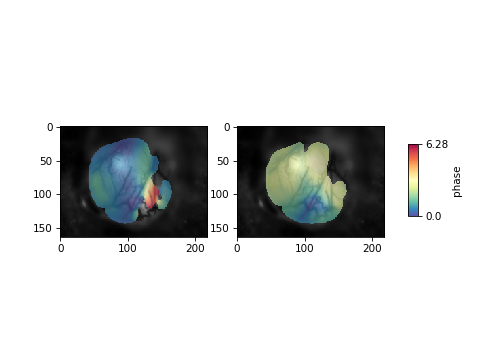

[Text(1,0,u'0.0'), Text(1,0,u'6.28')]

In [571]:
#### plot



fig, axes = pl.subplots(1, 2)
axes[0].imshow(surf, cmap='gray')
axes[1].imshow(surf, cmap='gray')
im = axes[0].imshow(phase_az, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)
im = axes[1].imshow(phase_el, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
fig.colorbar(im, cax=cbar_ax, ticks=[pmin, pmax], label='phase')
cbar_ax.set_yticklabels([round(pmin, 2), round(pmax,2)])

#pl.savefig(os.path.join(outdir, 'both_maps_%s_%s.svg' % (colormap, data_id)))

# Field sign maps

In [439]:
from matplotlib import ticker

def colorbar(fig, mappable, position='right', orientation='vertical'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    #last_axes = plt.gca()
    ax = mappable.axes
    #fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(position, size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, orientation=orientation)
    #plt.sca(last_axes)
    return cbar

In [574]:
# Calculate gradients
# h_map = phase_el_smooth.copy()
# v_map = phase_az_smooth.copy()

h_map = phase_el.copy()
v_map = phase_az.copy()

[h_gy, h_gx] = np.array(gradient_phase(h_map))
[v_gy, v_gx] = np.array(gradient_phase(v_map))

h_gdir = np.arctan2(h_gy, h_gx) # gradient direction
v_gdir = np.arctan2(v_gy, v_gx)

<IPython.core.display.Javascript object>


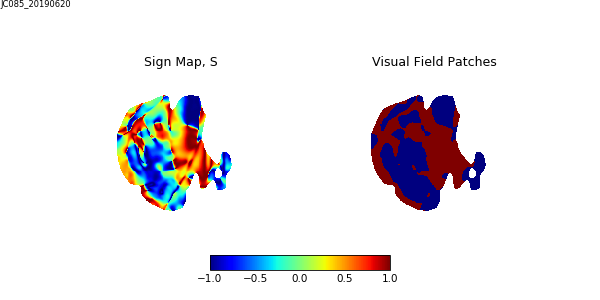

In [575]:
# Create sign map
gdiff = v_gdir-h_gdir
gdiff = (gdiff + math.pi) % (2*math.pi) - math.pi

#O=-1*np.sin(gdiff)
O=np.sin(gdiff) # LEFT goes w/ BOTTOM.  RIGHT goes w/ TOP.
S=np.sign(O) # Discretize into patches

fig, axn = pl.subplots(1,2, figsize=(8,4))
axn[0].set_title('Sign Map, S')
im0 = axn[0].imshow(O, cmap='jet'); axn[0].axis('off');
axn[1].set_title('Visual Field Patches')
im = axn[1].imshow(S, cmap='jet'); axn[1].axis('off');

cbar_ax = fig.add_axes([0.35, 0.1, 0.3, 0.05])
cbar_ticks = np.linspace(-1, 1, 5)
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks=cbar_ticks)
cbar_ax.tick_params(size=0)

label_figure(fig, fig_id)


In [526]:
# fig, axn = pl.subplots(1, 3)

# ax = axn[0]
# ax.imshow(h_gdir,cmap='jet');
# # plt.colorbar();
# #plt.axis('off')
# ax.set_title('H gdir')


# ax = axn[1]
# ax.imshow(v_gdir,cmap='jet');
# # plt.colorbar();
# #plt.axis('off')
# ax.set_title('V gdir')


# ax = axn[2]
# ax.imshow(S, cmap='jet');
# # plt.colorbar();
# #plt.axis('off')
# ax.set_title('Sign')




## Morphological steps to find boundaries

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


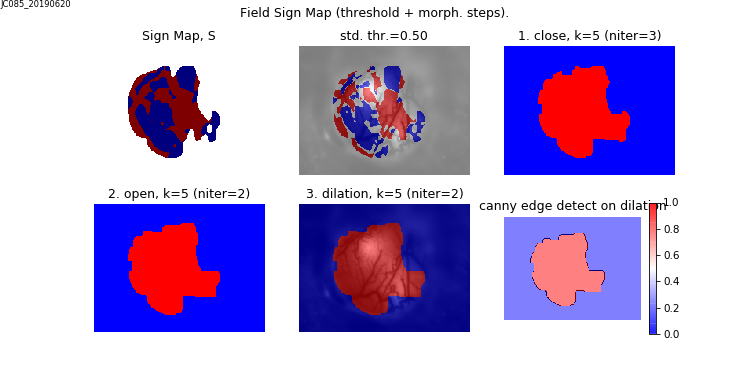

('/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps', 'sign_map_steps__JC085_20190620')


In [597]:

# Calculate STD, and threshold to separate areas (simple morph. step)
std_thresh = .5

O_sigma=np.nanstd(O)

S_thresh=np.zeros(np.shape(O))
S_thresh[O>(O_sigma*std_thresh)]=1
S_thresh[O<(-1*O_sigma*std_thresh)]=-1

fig = pl.figure(figsize=(10,5))
nr=2
nc=3


# 1. Unthresholded sign map, S 
# -----------------------------------------------------------
pl.subplot(nr, nc, 1)
pl.imshow(S, cmap='jet', alpha=1);
# plt.colorbar();
pl.axis('off')
pl.title('Sign Map, S')


# 2. Thresholded sign map, S 
# -----------------------------------------------------------
pl.subplot(nr, nc, 2)
pl.imshow(surface, cmap='gray')
pl.imshow(S_thresh,cmap='bwr', alpha=0.5);
pl.axis('off')
pl.title('std. thr.=%.2f' % std_thresh)
# plt.colorbar();


# 1. First perform morphological "closing" on |S_thresh|:
# This closes small holes, while leaving objects the same sz
# -----------------------------------------------------------
k1 = 5
niter = 3
kernel =  np.ones((k1, k1))
closing_s1 = cv2.morphologyEx(np.abs(S_thresh), cv2.MORPH_CLOSE, kernel, iterations=niter)
pl.subplot(nr, nc, 3)
pl.title('1. close, k=%s (niter=%i)' % (k1, niter))
pl.imshow(closing_s1, cmap='bwr')
pl.axis('off')


# 2.  Then, do an "opening"
# -----------------------------------------------------------
# Opening is basically erosion + dilation. Good for getting rid of noise.
# This sometimes misses borders.. (Criterion 2) -- see STEP 3. 
k2 = 5
niter=2
kernel = np.ones((k2, k2))
opening_1 = cv2.morphologyEx(closing_s1, cv2.MORPH_OPEN, kernel, iterations=niter)
pl.subplot(nr, nc, 4)
pl.title('2. open, k=%s (niter=%i)' % (k2, niter))
pl.imshow(opening_1, cmap='bwr')
pl.axis('off')

pl.suptitle('Field Sign Map (threshold + morph. steps).')
label_figure(fig, fig_id)


# 3.  Do "dilation: a.  Closing on abs(S-thresh)
# -----------------------------------------------------------
# Closing is dilation, then erosion. Good for closing small holes
k3 = 5 #5
niter = 2
kernel = np.ones((k3, k3))
#dilation = cv2.dilate(opening_1, kernel, iterations=niter)
dilation = cv2.morphologyEx(opening_1, cv2.MORPH_CLOSE, kernel, iterations=niter)

pl.subplot(nr, nc, 5)
pl.imshow(surface, cmap='gray')
pl.imshow(dilation, cmap='bwr', alpha=0.5)
pl.axis('off')
pl.title('3. dilation, k=%i (niter=%i)' % (k3, niter))



# 3.  Do "dialtion: a.  Closing on abs(S-thresh)
# -----------------------------------------------------------
cn_min = 0
cn_max = 1
dilationU8 = np.uint8(dilation)
canny_edges = cv2.Canny(dilationU8, cn_min, cn_max)

pl.subplot(nr, nc, 6)
pl.imshow(canny_edges, cmap='gray_r')
pl.axis('off')
pl.imshow(dilation, cmap='bwr', alpha=0.5)
pl.axis('off')
pl.title('canny edge detect on dilation')

pl.colorbar()

#figname = 'sign_map_steps__%s' % fig_id
#pl.savefig(os.path.join(outdir, '%s.png' % figname))

print(outdir, figname)

In [328]:
import skimage

In [329]:
sigma=3
low_threshold = 0.
high_threshold = 1.

edges = skimage.feature.canny(
    image=diluationU8,
    sigma=sigma,
    low_threshold=low_threshold,
    high_threshold=high_threshold,
)

AttributeError: 'module' object has no attribute 'feature'

In [326]:
# cn_min = 0
# cn_max = 1

# pl.figure(figsize=(12,4))

# pl.subplot(1,3,1)
# pl.imshow(surface, cmap='gray')
# pl.imshow(dilation, cmap='bwr', alpha=0.5)
# pl.title('')


# dilationU8 = np.uint8(dilation)
# canny_edges = cv2.Canny(dilationU8, cn_min, cn_max)
# pl.subplot(1,3,2)
# pl.imshow(canny_edges, cmap='gray_r')
# pl.axis('off')
# pl.imshow(dilation, cmap='bwr', alpha=0.5)
# pl.axis('off')
# pl.title('canny edge detect on dilation')

# # DILATE to fill? # This is obviously wrong, 
# # but not sure best way to do "thinning"...
# # --------------------------------------------------------------
# k_canny=3
# canny_edge_kernel = np.ones((k_canny, k_canny)) #np.ones((3,3))
# canny_close_kernel = np.ones((k_canny, k_canny)) #np.ones((3,3))
# canny_dilate = cv2.dilate(canny_edges, canny_edge_kernel, iterations = niter)
# canny_closed = cv2.morphologyEx(canny_dilate, cv2.MORPH_CLOSE, canny_close_kernel)
# pl.subplot(1,3,3)
# pl.imshow(canny_closed)
# pl.title('morph steps to clean up borders')

# pl.show()

## Draw overlay on retino maps

<IPython.core.display.Javascript object>


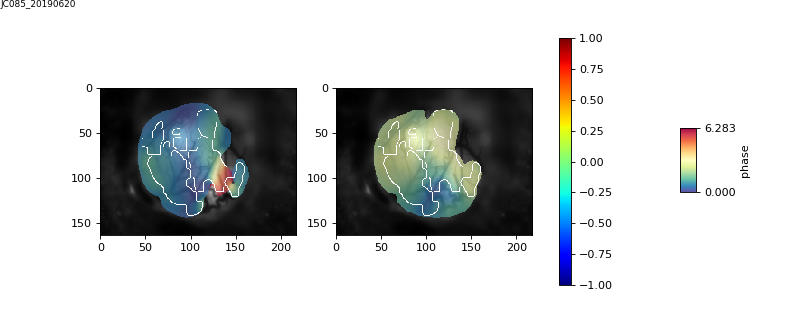

('/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps', 'overlay_borders_Spectral_r_JC085-20190620')


In [399]:
edge_mask = np.ma.masked_where(canny_edges == 0, canny_edges)




fig, axes = pl.subplots(1, 2, figsize=(10,4))
axes[0].imshow(surf, cmap='gray')
axes[1].imshow(surf, cmap='gray')
im = axes[0].imshow(phase_az, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)
axes[0].imshow(edge_mask, cmap='gray_r')

im = axes[1].imshow(phase_el, cmap=cmap_phase, vmin=pmin, vmax=pmax, alpha=0.6)
axes[1].imshow(edge_mask, cmap='gray_r')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.4, 0.02, 0.2])
cbar_ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
fig.colorbar(im, cax=cbar_ax, ticks=[pmin, pmax], label='phase')
cbar_ax.set_yticklabels([round(pmin, 2), round(pmax,2)])

label_figure(fig, fig_id)
figname = 'overlay_borders_%s_%s' % (colormap, data_id)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
print(outdir, figname)

In [244]:

pl.imshow(canny_edges, cmap='jet')
pl.colorbar()

In [221]:
# Marker labelling
ret, markers = cv2.connectedComponents(dilationU8)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

<IPython.core.display.Javascript object>


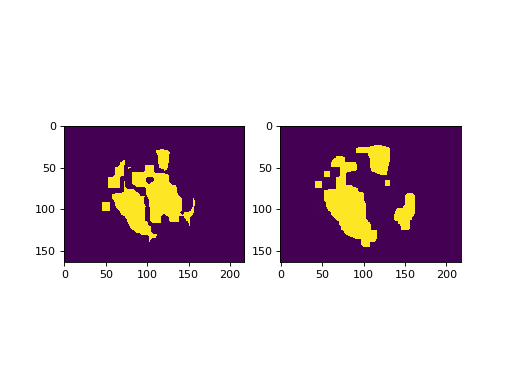

In [222]:
pl.figure()
pl.imshow(markers, cmap='jet')

In [ ]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]


# 2p

In [14]:
import cPickle as pkl
import h5py

In [18]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session2p = '20190522'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run2'

avgtraces_path = glob.glob(os.path.join(rootdir, animalid, session2p, fov, retinorun, 'retino_analysis', 
                                  'analysis*', 'traces', 'averaged_roi_traces.pkl'))[0]
retinodir = avgtraces_path.split('/traces/')[0]
print(retinodir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a


In [19]:
with open(avgtraces_path, 'rb') as f:
    avgtraces = pkl.load(f)

In [20]:
avgtraces.keys()

['source_tifs', 'traces', 'RETINOID', 'masks', 'mwinfo', 'conditions']

In [21]:
trials_by_cond = avgtraces['conditions']
trials_by_cond

{u'bottom': [3, 5, 9],
 u'left': [11, 1, 4],
 u'right': [12, 2, 8],
 u'top': [10, 7, 6]}

In [37]:
retino_dpath = os.path.join(os.path.split(avgtraces_path)[0], 'extracted_traces.h5')
tfile = h5py.File(retino_dpath, 'r')
tfile.keys()

[u'File001',
 u'File002',
 u'File003',
 u'File004',
 u'File005',
 u'File006',
 u'File007',
 u'File008',
 u'File009',
 u'File010',
 u'File011',
 u'File012']

# Visualize 1 condition 

In [25]:
currcond = 'right'

In [26]:
stiminfo = avgtraces['traces'][currcond]['info']
stiminfo

{'frame_rate': 44.6528, 'n_reps': 3, 'stimfreq': 0.24, 'stimulus': u'right'}

In [27]:
fr = float(stiminfo['frame_rate'])
n_frames = float(avgtraces['traces'][currcond]['traces'].shape[-1])
stim_freq = float(stiminfo['stimfreq'])
stimperiod = 1./stim_freq

n_cycles = int(round((n_frames/fr) / stimperiod))
n_frames_per_cycle = int(np.floor(stimperiod * fr))

cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

In [28]:
cycle_starts

array([   0,  186,  372,  558,  744,  930, 1116, 1302, 1488, 1674, 1860,
       2046])

#### average traces

In [30]:
xticks = np.linspace(0, n_frames, 5)
xticklabels = [round(float(f)/fr) for f in xticks]


In [31]:
rois_plot = [57, 175, 247]
colors = ['royalblue', 'darkorange', 'forestgreen']

<IPython.core.display.Javascript object>


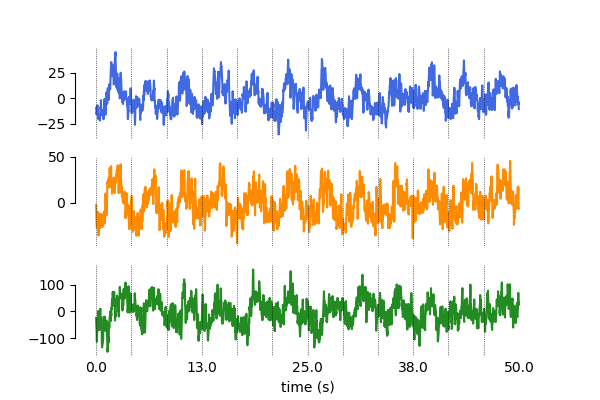

Text(0.5,0,u'time (s)')

In [36]:
fig, axes = pl.subplots(3, 1, figsize=(6,4), sharex=True, sharey=False)
for ri, (ax, roi) in enumerate(zip(axes, rois_plot)):
    meanval = avgtraces['traces']['right']['traces'][roi, :].mean()
    ax.plot( (avgtraces['traces']['right']['traces'][roi, :]-meanval) / meanval , color=colors[ri])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    sns.despine(ax=ax, trim=True, bottom=True)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, linestyle=':', color='k', lw=0.5)
    ax.tick_params(which='both', axis='x', length=0)
        
ax.set_xlabel('time (s)')

#figname = 'example-traces_cond-%s_%s' % (currcond, data_id)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
#print figname

# Reprocess with raw traces

In [38]:
trials_by_cond

{u'bottom': [3, 5, 9],
 u'left': [11, 1, 4],
 u'right': [12, 2, 8],
 u'top': [10, 7, 6]}

In [39]:
currcond = 'right'

In [40]:
tfile['File001'].keys()

[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']

# Do FFT

In [ ]:
# label frequency bins
freqs = np.fft.fftfreq(n_frames, float(1/fr))
idx = np.argsort(freqs)
freqs=freqs[idx]
print(freqs)

# exclude DC offset from data
freqs=freqs[int(np.round(n_frames/2.))+1:]

# Identify freq idx:
freq_idx=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
top_freq_idx=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
print("Target freq: %.3f Hz" % freqs[freq_idx])
#max_mod_idx=np.argmax(magnitudes[freq_idx, :],0)#best pixel index
